In [19]:
import numpy as np
import ast
import urllib
import random
import collections
import scipy.optimize
from sklearn import linear_model  # Perform Logistic Regression
from sklearn.preprocessing import LabelEncoder   # This label encoder is used to find the labels
from sklearn.preprocessing import OneHotEncoder  # One hot encoding is used here

In [20]:
def parseDataFromFile(fname):
    for l in open(fname):
        yield ast.literal_eval(l)

In [21]:
data = list(parseDataFromFile("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Homework2\\beer_50000.json"))

In [22]:
print(data[1])
# for datum in data:
#     print("Ratings are {}, {}, {}, {} and {}".format(datum['review/appearance'],\
#                                                      datum['review/palate'],\
#                                                      datum['review/taste'],\
#                                                      datum['review/overall'],\
#                                                      datum['review/aroma']))

{'review/appearance': 3.0, 'beer/style': 'English Strong Ale', 'review/palate': 3.0, 'review/taste': 3.0, 'beer/name': 'Red Moon', 'review/timeUnix': 1235915097, 'beer/ABV': 6.2, 'beer/beerId': '48213', 'beer/brewerId': '10325', 'review/timeStruct': {'isdst': 0, 'mday': 1, 'hour': 13, 'min': 44, 'sec': 57, 'mon': 3, 'year': 2009, 'yday': 60, 'wday': 6}, 'review/overall': 3.0, 'review/text': 'Dark red color, light beige foam, average.\tIn the smell malt and caramel, not really light.\tAgain malt and caramel in the taste, not bad in the end.\tMaybe a note of honey in teh back, and a light fruitiness.\tAverage body.\tIn the aftertaste a light bitterness, with the malt and red fruit.\tNothing exceptional, but not bad, drinkable beer.', 'user/profileName': 'stcules', 'review/aroma': 2.5}


In [23]:
random.shuffle(data) # random shuffling of data

In [24]:
# Compute the confusion matrix for the given set of predictions and actual values
def compute_confusion_matrix(Y_actual, Y_predict):
    """ This function is used to compute the confusion matrix"""
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    assert(len(Y_actual) == len(Y_predict))
    for i in range(len(Y_actual)):
        if(Y_actual[i] == 1 and Y_predict[i] == 1):
            TP += 1
        elif(Y_actual[i] == 0 and Y_predict[i] == 1):
            FP += 1
        elif(Y_actual[i] == 0 and Y_predict[i] == 0):
            TN += 1
        elif(Y_actual[i] == 1 and Y_predict[i] == 0):
            FN += 1
    return (TP, TN, FP, FN)

# Compute the ratios for computing the TP, TN, FP and FN
def compute_rates(TP, TN, FP, FN):
    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)
    BER = 0.5 * (FPR + FNR)
    return (TPR, TNR, FPR, FNR, BER)

In [25]:
## Diagnostic Tasks (Week 2)
## Build a classifier to check if the Beer is highly alcoholic (ABV greater than 7%)
def feature(datum):
    categoryCounts = collections.defaultdict(int)
    for d in datum:
        categoryCounts[d['beer/style']] += 1

    categories = [c for c in categoryCounts if categoryCounts[c] > 1000]
    feat = [str(d['beer/style']) for d in datum if 'beer/style' in d]
    labels = [1 if d['beer/ABV'] > 7.0 else 0 for d in datum if 'beer/style' in d]
    catID = dict(zip(list(categories), range(len(categories))))
    return (feat, labels, catID)

In [26]:
# Obtain the encoding and features from the input data
(X, Y, encoding) = feature(data)
length = len(X)
# Compute the numerical labels for the categorical data
numerical_labels = np.array(list(encoding.values()))
#for key, value in encoding.items():
    #print("Key, value = {}, {}".format(key, value))
# Convert the labeled encoding to one hot encoding
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
one_hot_encoded = {}
one_hot_encoder.fit(numerical_labels.reshape(-1, 1))
OneHotEncoded = one_hot_encoder.transform(numerical_labels.reshape(-1, 1)).toarray()
#print(OneHotEncoded)
max_length = -1
# Here, we print the key and value for the one hot encoded key/value
for i in range(len(list(encoding.keys()))):
    key = list(encoding.keys())[i]
    one_hot_encoded[key] = OneHotEncoded[i]
    #print("Key = {}, value = {}".format(key, one_hot_encoded[key]))
    max_length = max(max_length, OneHotEncoded[i].size)
    
print("Max length = {}".format(max_length))
X_train = []
X_test = []
for x in X[ : length // 2]:
    if str(x) in one_hot_encoded:
        X_train.append(np.insert(one_hot_encoded[x], 0 , 1))
    else:
        y = np.zeros(max_length)
        z = np.insert(y, 0, 1)
        X_train.append(z)

for x in X[length // 2 : ]:
    if str(x) in one_hot_encoded:
        X_test.append(np.insert(one_hot_encoded[x], 0 , 1))
    else:
        y = np.zeros(max_length)
        z = np.insert(y, 0, 1)
        X_test.append(z)
        
X_train = np.array(X_train)
X_test = np.array(X_test)
# print(X[:10])
# print(X_train[:10])
# print("The original input is: {}".format(X[2]))
# print("The modified vector is: {}".format(X_train[2]))
Y_train = np.array(Y[ : length//2])
Y_test = np.array(Y[length//2 : ])
model = linear_model.LogisticRegression(C=10.0, class_weight='balanced')
model.fit(X_train, Y_train)
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
print(sum(test_predictions == Y_test)/len(test_predictions))
(TP, TN, FP, FN) = compute_confusion_matrix(Y_test, test_predictions)
accuracy = (TP + TN) / (TP + TN + FP + FN)
# The accuracy of the predictor is given as follows -->
print("The accuracy of the predictor is {}".format(accuracy))
print("TP, TN, FP, FN are {},{},{}, and {}".format(TP, TN, FP, FN))
(TPR, TNR, FPR, FNR, BER) = compute_rates(TP,TN,FP,FN)
print("TPR, TNR, FPR, FNR are {},{},{}, and {}".format(TPR, TNR, FPR, FNR))
print("The balanced error rate is {}".format(BER))

Max length = 13
0.84612
The accuracy of the predictor is 0.84612
TP, TN, FP, FN are 8012,13141,155, and 3692
TPR, TNR, FPR, FNR are 0.6845522898154477,0.9883423586040915,0.011657641395908544, and 0.3154477101845523
The balanced error rate is 0.16355267579023042


### Question 2 - Extend the model to include a vector of five ratings (different reviews)

In [27]:
def feature(datum):
    categoryCounts = collections.defaultdict(int)
    for d in datum:
        categoryCounts[d['beer/style']] += 1

    categories = [c for c in categoryCounts if categoryCounts[c] > 1000]
    max_length = -1
    for d in datum:
        max_length = max(max_length, len(d['review/text']))
    
    print("Max Length is {}".format(max_length))
    
    feat = [[str(d['beer/style']), float(d['review/appearance']), float(d['review/palate']), \
             float(d['review/taste']), float(d['review/overall']), float(d['review/aroma']), \
             float(len(d['review/text'])/max_length)] for d in datum if 'beer/style' in d]
    labels = [1 if d['beer/ABV'] > 7.0 else 0 for d in datum if 'beer/style' in d]
    catID = dict(zip(list(categories), range(len(categories))))
    return (feat, labels, catID)

(X, Y, encoding) = feature(data)
length = len(X)
# Compute the numerical labels for the categorical data
numerical_labels = np.array(list(encoding.values()))

# Convert the labeled encoding to one hot encoding
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
one_hot_encoded = {}
one_hot_encoder.fit(numerical_labels.reshape(-1, 1))
OneHotEncoded = one_hot_encoder.transform(numerical_labels.reshape(-1, 1)).toarray()
print(OneHotEncoded)

max_length = -1
# Here, we print the key and value for the one hot encoded key/value
# We also compute the max length required for 
for i in range(len(list(encoding.keys()))):
    key = list(encoding.keys())[i]
    one_hot_encoded[key] = OneHotEncoded[i]
    max_length = max(max_length, OneHotEncoded[i].size)

X_train = []
X_test = []
for x in X[ : length // 2]:
    if str(x[0]) in one_hot_encoded:
        resultant_array = np.concatenate([np.insert(one_hot_encoded[str(x[0])], 0 , 1), np.array(x[1:])])
        X_train.append(resultant_array)
    else:
        y = np.zeros(max_length)
        z = np.concatenate([np.insert(y, 0, 1), np.array(x[1:])])
        X_train.append(z)

for x in X[length // 2 : ]:
    if str(x[0]) in one_hot_encoded:
        resultant_array = np.concatenate([np.insert(one_hot_encoded[str(x[0])], 0 , 1), np.array(x[1:])])
        X_test.append(resultant_array)
    else:
        y = np.zeros(max_length)
        z = np.concatenate([np.insert(y, 0, 1), np.array(x[1:])])
        X_test.append(z)
        
Y_train = np.array(Y[ : length//2])
Y_test = np.array(Y[length//2 : ])

# The encoding for the given set of features looks as follows
model = linear_model.LogisticRegression(C=10.0, class_weight='balanced', max_iter=200)
model.fit(X_train, Y_train)
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
print(sum(test_predictions == Y_test)/len(test_predictions))
(TP, TN, FP, FN) = compute_confusion_matrix(Y_test, test_predictions)
# The accuracy of the predictor is given as follows
accuracy = (TP + TN) / (TP + TN + FP + FN)
print("The accuracy of the predictor is {}".format(accuracy))
print("TP, TN, FP, FN are {},{},{}, and {}".format(TP, TN, FP, FN))
(TPR, TNR, FPR, FNR, BER) = compute_rates(TP,TN,FP,FN)
print("TPR, TNR, FPR, FNR are {},{},{}, and {}".format(TPR, TNR, FPR, FNR))
print("The balanced error rate is {}".format(BER))

Max Length is 4721
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
0.85932
The accuracy of the predictor is 0.85932
TP, TN, FP, FN are 9051,12432,864, and 2653
TPR, TNR, FPR, FNR are 0.7733253588516746,0.9350180505415162,0.06498194945848375, and 0.22667464114832536
The balanced error rate is 0.14582829530340455


C:\Users\ramasarma\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Question 3 - Regularization pipeline

Max Length is 4721
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
4
[array([1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 4.        ,
       3.5       , 4.        , 4.        , 3.5       , 0.10929888]), array([1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.      

C:\Users\ramasarma\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


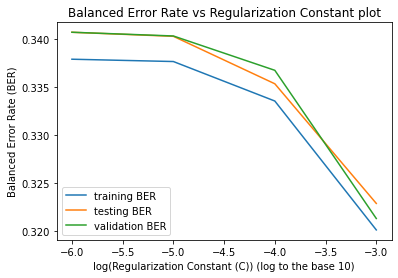

In [40]:
# We import this matplotlib package for further analysis using PyPlot
import matplotlib.pyplot as plt
import math

(X, Y, encoding) = feature(data)
length = len(X)
# Compute the numerical labels for the categorical data
numerical_labels = np.array(list(encoding.values()))

# Convert the labeled encoding to one hot encoding
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
one_hot_encoded = {}
one_hot_encoder.fit(numerical_labels.reshape(-1, 1))
OneHotEncoded = one_hot_encoder.transform(numerical_labels.reshape(-1, 1)).toarray()
print(OneHotEncoded)
#C = np.arange(10 ** -6,10 ** -3,5 *(10 ** -6)).tolist()
C = [10 ** -6, 10 ** -5, 10 ** -4, 10 ** -3]
X_train = []
X_test = []
X_validate = []
Y_train = []
Y_test = []
Y_validate = []
training_split = [0, (length//2), (length//4)*3, length]
print(len(training_split))
left = 0
right = 1

while right < len(training_split):
    #print("Left = {}, right = {}".format(left, right))
    for x in X[training_split[left]:training_split[right]]:
        resultant_array = []
        if str(x[0]) in one_hot_encoded:
            resultant_array = np.concatenate([np.insert(one_hot_encoded[str(x[0])], 0 , 1), np.array(x[1:])])
        else:
            y = np.zeros(max_length)
            resultant_array = np.concatenate([np.insert(y, 0, 1), np.array(x[1:])])
        #print(resultant_array)
        if right == 1:
            X_train.append(resultant_array)
        elif right == 2:
            X_test.append(resultant_array)
        elif right == 3:
            X_validate.append(resultant_array)
    
    
    array = np.array(Y[training_split[left]:training_split[right]])
    if right == 1:
        Y_train = array
    elif right == 2:
        Y_test = array
    elif right == 3:
        Y_validate = array
        
    right += 1
    left += 1

print(X_train[0:3])
BER_values = collections.defaultdict()
for val in C:
    # Plot Training, Testing and Validation BER
    model = linear_model.LogisticRegression(C=val, class_weight='balanced', max_iter=2000)
    model.fit(X_train, Y_train)
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    validate_predictions = model.predict(X_validate)
    (TP, TN, FP, FN) = compute_confusion_matrix(Y_train, train_predictions)
    (TP_test, TN_test, FP_test, FN_test) = compute_confusion_matrix(Y_test, test_predictions)
    (TP_val, TN_val, FP_val, FN_val) = compute_confusion_matrix(Y_validate, validate_predictions)
    accuracy_train = (TP + TN) / (TP + TN + FP + FN)
    accuracy_test = (TP_test + TN_test) / (TP_test + TN_test + FP_test + FN_test)
    accuracy_validate = (TP_val + TN_val) / (TP_val + TN_val + FP_val + FN_val)

    (TPR, TNR, FPR, FNR, BER) = compute_rates(TP,TN,FP,FN)
    (TPR_test, TNR_test, FPR_test, FNR_test, BER_test) = compute_rates(TP_test,TN_test,FP_test,FN_test)
    (TPR_val, TNR_val, FPR_val, FNR_val, BER_val) = compute_rates(TP_val,TN_val,FP_val,FN_val)

    BER_values[val] = (BER, BER_test, BER_val)

x = []
y0 = []
y1 = []
y2 = []
for key, values in BER_values.items():
    x.append(math.log(key)/math.log(10))
    y0.append(values[0])
    y1.append(values[1])
    y2.append(values[2])
print(x)
print("Values of Train BER are {}".format(y0))
print("Values of Test BER are {}".format(y1))
print("Values of Validation BER are {}".format(y2))
fig = plt.figure()
fig.clear()
plt.title('Balanced Error Rate vs Regularization Constant plot')
plt.xlabel('log(Regularization Constant (C)) (log to the base 10)')
plt.ylabel('Balanced Error Rate (BER)')
ax = fig.add_subplot(1, 1, 1)
A, = ax.plot(x, y0, color='tab:blue')
B, = ax.plot(x, y1, color='tab:orange')
C, = ax.plot(x, y2, color='tab:green')
plt.legend([A,B,C], ["training BER", "testing BER", "validation BER"])

### Question 5 - Precision Recall Curve Plot

Average precision-recall score: 0.58


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.58')

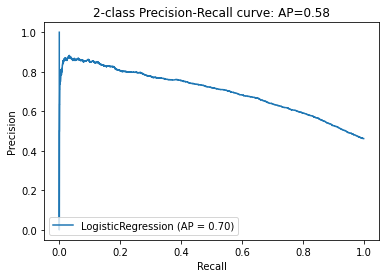

In [48]:
# We import this matplotlib package for further analysis using PyPlot
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

test_predictions = model.predict(X_test)
average_precision = average_precision_score(Y_test, test_predictions)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))
disp = plot_precision_recall_curve(model, X_test, Y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

### Task : Community Detection - Data Parsing

In [12]:
def parseDataFromFile(fname):
    lines = []
    for line in open(fname):
        content = line.rstrip('\n').split(' ')
        content_int = []
        for val in content:
            content_int.append(int(val))
        lines.append(tuple(content_int))
    return lines
data = list(parseDataFromFile("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Homework2\\egonet.txt"))
print(data[0])

(881, 858)


### Question 6 - Computed Largest connected component and it's size

540 61


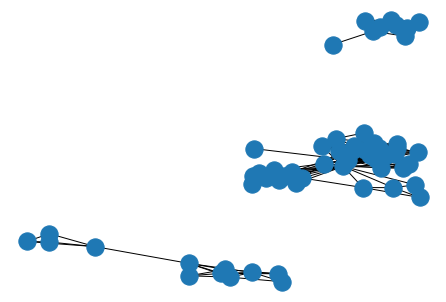

61 270
The number of connected components in the graph are 3
The size of the largest connected component in the graph is 40
The largest connected component in the graph is {769, 772, 774, 798, 800, 803, 804, 805, 810, 811, 819, 823, 697, 825, 828, 830, 703, 708, 840, 713, 719, 856, 729, 861, 863, 864, 869, 745, 747, 876, 878, 880, 753, 882, 884, 886, 888, 889, 890, 893}


<Figure size 432x288 with 0 Axes>

In [15]:
import urllib
import networkx as nx
import matplotlib.pyplot as plt

edges = set()
nodes = set()
for edge in open("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Homework2\\egonet.txt", 'r'):
    x,y = edge.split()
    x,y = int(x),int(y)
    edges.add((x,y))
    edges.add((y,x))
    nodes.add(x)
    nodes.add(y)
print(len(edges), len(nodes))
G = nx.Graph()
for e in edges:
    G.add_edge(e[0],e[1])
nx.draw(G)
plt.show()
plt.clf()


# G = nx.Graph()
# G.add_edges_from(data)
print(G.number_of_nodes(), G.number_of_edges())
connected_components = nx.algorithms.components.number_connected_components(G)
print("The number of connected components in the graph are {}".format(connected_components))
largest_connected_component = max(nx.connected_components(G), key=len)
length_cc = len(largest_connected_component)
print("The size of the largest connected component in the graph is {}".format(length_cc))
print("The largest connected component in the graph is {}".format(largest_connected_component))

### Question 7 - Greedy implementation (based on the ID)

In [16]:
largest_cc = [node for node in largest_connected_component]
largest_cc.sort()
A = largest_cc[:length_cc//2]
B = largest_cc[length_cc//2:]
print("The first 50% split is {}".format(A))
print("The second 50% split is {}".format(B))
normalized_cuts = nx.algorithms.normalized_cut_size(G, A, B)
print("Number of normalized cuts = {}".format(normalized_cuts))

The first 50% split is [697, 703, 708, 713, 719, 729, 745, 747, 753, 769, 772, 774, 798, 800, 803, 804, 805, 810, 811, 819]
The second 50% split is [823, 825, 828, 830, 840, 856, 861, 863, 864, 869, 876, 878, 880, 882, 884, 886, 888, 889, 890, 893]
Number of normalized cuts = 0.8448117539026632


### Question 8 - Greedy algorithm implementation

In [17]:
import sys

largest_cc = [node for node in largest_connected_component]
largest_cc.sort()
A = largest_cc[:length_cc//2]
B = largest_cc[length_cc//2:]
current_norm_cost = normalized_cuts
idx_A = 0
prev_norm_cost = current_norm_cost
consecutive_iter_count = 0
min_cut_ID = 1000
#while(prev_norm_cost != current_norm_cost or consecutive_iter_count < 100):
while(True):
    # Choose the node that results in minimizing cut cost
    norm_cut_cost_A = [sys.maxsize] * len(A)
    norm_cut_cost_B = [sys.maxsize] * len(B)
    idx_A, idx_B = 0, 0
    min_cut_cost = sys.maxsize
    for idx_A in range(len(A)):
        value = A.pop(idx_A)
        B.append(value)
        new_norm_cost = nx.algorithms.normalized_cut_size(G, A, B)        
#         print("At idx_A = {}, new_norm_cost = {}, with len(A) = {}, len(B) = {}".\
#               format(idx_A, new_norm_cost, len(A), len(B)))
        if(new_norm_cost <= current_norm_cost):
            norm_cut_cost_A[idx_A] = new_norm_cost
            A.insert(idx_A, value)
            B = B[:-1]
        else:
            # Reset the deletion
            A.insert(idx_A, value)
            B = B[:-1]
        
    for idx_B in range(len(B)):
        value = B.pop(idx_B)
        A.append(value)
        new_norm_cost = nx.algorithms.normalized_cut_size(G, A, B)
#         print("At idx_B = {}, new_norm_cost = {}, with len(A) = {}, len(B) = {}".\
#               format(idx_B, new_norm_cost, len(A), len(B)))
        if(new_norm_cost <= current_norm_cost):
            norm_cut_cost_B[idx_B] = new_norm_cost
            B.insert(idx_B, value)
            A = A[:-1]
        else:
            # Reset the deletion
            B.insert(idx_B, value)
            A = A[:-1]
    
    # We have the indices and the costs for each move for A and B
    move_from_A_to_B = False
    move_from_B_to_A = False
#     print("Contents of norm_cut_cost A are")
#     print(norm_cut_cost_A)
#     print("Contents of norm_cut_cost B are")
#     print(norm_cut_cost_B)
    for i in range(len(norm_cut_cost_A)):
        if(norm_cut_cost_A[i] != sys.maxsize):
            if(norm_cut_cost_A[i] <= min_cut_cost):
                #Tie Breaker logic
                if(norm_cut_cost_A[i] == min_cut_cost):
                    if(A[i] < min_cut_ID):
                        min_cut_ID = A[i]
                        move_from_A_to_B = True
                        move_from_B_to_A = False
                    # Dont update the min cut ID
                else:
                    # min_cut_cost > norm_cut_cost_A[i]
                    min_cut_ID = A[i]
                    move_from_A_to_B = True
                    move_from_B_to_A = False
                # Update the min cut cost
                min_cut_cost = norm_cut_cost_A[i]
    #print("At the end of processing norm_cut_cost_A, we get min_cut_cost = {}".format(min_cut_cost))
    for i in range(len(norm_cut_cost_B)):        
        if(norm_cut_cost_B[i] != sys.maxsize):
            if(norm_cut_cost_B[i] <= min_cut_cost):
                #Tie Breaker logic
                if(norm_cut_cost_B[i] == min_cut_cost):
                    if(B[i] < min_cut_ID):
                        min_cut_ID = B[i]
                        move_from_A_to_B = False
                        move_from_B_to_A = True
                    # Dont update the min cut ID
                else:
                    # Case when the min_cut_ID should be updated
                    min_cut_ID = B[i]
                    move_from_A_to_B = False
                    move_from_B_to_A = True
                # Update the min cut cost
                min_cut_cost = norm_cut_cost_B[i]
    #print("At the end of processing norm_cut_cost_B, we get min_cut_cost = {}".format(min_cut_cost))
    prev_norm_cost = current_norm_cost
#     print("Min cut cost, move_from_A_to_B, move_from_B_to_A = {}, {} and {}".\
#           format(min_cut_cost, move_from_A_to_B, move_from_B_to_A))
    if min_cut_cost != sys.maxsize:
        # Move it from A to B
        if(move_from_A_to_B):
            A.remove(min_cut_ID)
            B.append(min_cut_ID)
            consecutive_iter_count = 0
            current_norm_cost = min_cut_cost
        # Move it from B to A
        elif(move_from_B_to_A):
            B.remove(min_cut_ID)
            A.append(min_cut_ID)
            consecutive_iter_count = 0
            current_norm_cost = min_cut_cost
        else: # No movements from A to B
            consecutive_iter_count += 1
    else:
        consecutive_iter_count += 1
    
    print("Prev norm cost, current norm cost, consecutive_iter_count and min_cut_ID = {}, {}, {} and {}".\
          format(prev_norm_cost, current_norm_cost, consecutive_iter_count, min_cut_ID))
    
    if(move_from_B_to_A == False and move_from_A_to_B == False):
        break
print("After performing the split, we get the following clusters of nodes,\n A = {} and \n B = {}".format(A, B))
print("The normalized cut cost after performing the split is {}".format(current_norm_cost))

Prev norm cost, current norm cost, consecutive_iter_count and min_cut_ID = 0.8448117539026632, 0.7746639325586694, 0 and 729
Prev norm cost, current norm cost, consecutive_iter_count and min_cut_ID = 0.7746639325586694, 0.6909090909090909, 0 and 804
Prev norm cost, current norm cost, consecutive_iter_count and min_cut_ID = 0.6909090909090909, 0.6136680613668061, 0 and 828
Prev norm cost, current norm cost, consecutive_iter_count and min_cut_ID = 0.6136680613668061, 0.5332652931045481, 0 and 823
Prev norm cost, current norm cost, consecutive_iter_count and min_cut_ID = 0.5332652931045481, 0.4515382431930828, 0 and 830
Prev norm cost, current norm cost, consecutive_iter_count and min_cut_ID = 0.4515382431930828, 0.35752979414951247, 0 and 840
Prev norm cost, current norm cost, consecutive_iter_count and min_cut_ID = 0.35752979414951247, 0.2942872298715376, 0 and 880
Prev norm cost, current norm cost, consecutive_iter_count and min_cut_ID = 0.2942872298715376, 0.25900025900025897, 0 and 8